In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import fmin_bfgs
from tqdm import tqdm,tqdm_notebook
import matplotlib.pyplot as plt

# custom percentile function to exactly replicate matlab
def quantile(x,q):
    n = len(x)
    y = np.sort(x)
    return(np.interp(q, np.linspace(1/(2*n), (2*n-1)/(2*n), n), y))

def prctile(x,p):
    return(quantile(x,np.array(p)/100))
# discussion: https://stackoverflow.com/questions/24764966/numpy-percentile-function-different-from-matlabs-percentile-function

In [2]:
# load GKX data 
data_stocks_dir = './data_stocks/'
micro = pd.read_pickle(data_stocks_dir + 'returns_chars_panel_raw.pkl') # use dropbox links to download this
macro = pd.read_pickle(data_stocks_dir + 'macro_timeseries.pkl')
df = pd.merge(micro,macro,on='date',how='left',suffixes=['','_macro']) # include macro predictors

# Policy Gradient with Neural Network

100%|██████████| 42/42 [03:42<00:00,  5.30s/it]


CPU times: user 3min 28s, sys: 23.6 s, total: 3min 51s
Wall time: 3min 43s


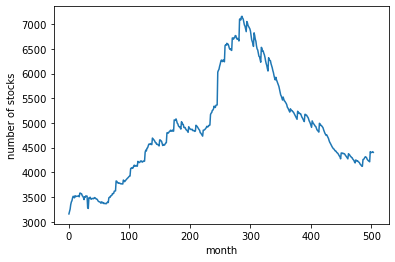

In [3]:
%%time
# clean data
wm,x,ret,rf = [],[],[],[] # lists holding data for each period
mean_chars = [] # for debug
# for year in tqdm(range(1974,2016)): # using data from 1974 as in BSV, but longer sample
for year in tqdm(range(1974,2016)): # using data from 1974 as in BSV, but longer sample
    for month in range(1,13):
        dta = df[(df['date'].dt.year==year) & (df['date'].dt.month==month)] # data for this period
        
        cols = ['mvel1','bm','mom12m','ret','rfree']
        dta = dta[cols].dropna()
                
        # cleaning: remove size below 0.2 percentile and negative beme
        min_me = prctile(dta['mvel1'],0.2)
        dta = dta[(dta['mvel1']>=min_me) & (dta['bm']>=0)]
        
        # get value weights for bsv policy
        mv = dta['mvel1'].values.reshape(-1,1)
        wm.append(mv/np.sum(mv))
        
        # get normalised characteristics for policy
        sz = np.log(dta['mvel1'])
        btm = np.log(1+dta['bm'])
        mom = dta['mom12m']
        char = np.vstack([sz,btm,mom]).T
        mean_chars.append(np.mean(char,axis=0))
        char -= np.mean(char,axis=0)
        char /= np.std(char,axis=0)
        x.append(char)
        
        # get returns
        ret.append(dta['ret'].values.reshape(-1,1))
        
        # risk free rate
        rf.append(dta['rfree'].mean())
        
plt.plot([len(r) for r in ret])
plt.xlabel('month')
plt.ylabel('number of stocks')
del df, micro, macro

In [4]:
def initialize_network(layers):
    # random initialization of parameters of neural network
    np.random.seed(108)
    pars = [] # conveniently to store parameters in a list of dictionaries
    for j in range(1,len(layers)): # loop over layers
        dictionary = {'weight' : np.random.randn(layers[j],layers[j-1]), # initialize matrix W(l) of weights
                      'bias' : np.random.randn(layers[j],1)} # initialize vector b(l) of biases
        pars.append(dictionary)
    return pars

In [5]:
def unstack_theta(original_theta, layers):
    flattened_theta = []
    for i in range(len(layers) - 1):
        flattened_theta.extend(np.array(original_theta[i]['weight']).flatten())
        flattened_theta.extend(np.array(original_theta[i]['bias']).flatten())
    return flattened_theta

def stack_theta(flattened_theta, layers):
    original_theta = []
    index = 0
    for i in range(len(layers) - 1):
        retrieve_len = layers[i+1] * layers[i]
        weight_list = np.array(flattened_theta[index:index + retrieve_len]).reshape(layers[i+1], layers[i])
        index += retrieve_len
        retrieve_len = layers[i+1] * 1
        bias_list = np.array(flattened_theta[index:index + retrieve_len]).reshape(layers[i+1], 1)
        index += retrieve_len
        original_theta.append({'weight': weight_list, 'bias': bias_list})
    return original_theta

In [6]:
def forward(X,pars):
    
    # make lists to store elements of the graph in memory
    Zs,Hs = [],[]
    
    # initialize inputs
    H = X.T
    
    # loop over layers
    for j in range(len(pars)):
        
        # get parameters for this layer      
        W = pars[j]['weight']
        b = pars[j]['bias']
                
        # activations and output
        Z = np.matmul(W,H) + b 
        H = Z if j+1 == len(pars) else Z*(Z>0)
         
        # save to list
        Zs.append(Z)
        Hs.append(H)
    
    return Zs,Hs
    # return Hs[-1].flatten()
# NB: we could also explicitly return predictions but this is sufficient  and cleaner

def backprop(Zs,Hs,X,pars,delta_y=1e-5):
    
    # setup list for gradients
    grads = []
    
    # data size
    m = X.shape[0]

    # loop over layers
    for j in range(len(pars))[::-1]:
        Z = Zs[j]
        H = Hs[j]
        W = pars[j]['weight']
        
        # get activations gradient
        dZ = (H - (H - delta_y)) if j+1 == len(pars) else (Z > 0) * dH
        # print('dZ shape', dZ.shape)
        
        # get input from previous layer
        H_back = Hs[j-1] if j>0 else X.T
        # print('H_back shape', H_back.shape)
                
        # get parameter gradients
        dZdW_list = []
        dZdb_list = []
        for k in range(m):
            # print('dZ[:, k] shape', dZ[:,k:k+1].shape)
            # print('H_back[:,k] shape', H_back[:,k:k+1].shape)
            dW = np.matmul(dZ[:,k:k+1],H_back[:,k:k+1].T)
            # print('dW shape', dW.shape)
            db = dZ[:, k:k+1]
            # db = np.sum(dZ,axis=1,keepdims=True) / m
            # print('db shape', db.shape)
            dZdW = np.divide(np.zeros_like(dW) + delta_y, dW, out=np.zeros_like(dW), where=dW!=0)
            dZdb = np.divide(np.zeros_like(db) + delta_y, db, out=np.zeros_like(db), where=db!=0)
            dZdW_list.append(dZdW)
            dZdb_list.append(dZdb)
        
        # save to list
        grads.append({'weight' : dZdW_list, 'bias' : dZdb_list})
        grads = grads[::-1]
        
        # move to next layer
        if j>0: dH = np.matmul(W.T,dZ)

    flattened_theta_list = []
    for i in range(m):
        flattened_theta = []
        for j in range(len(pars)):
            flattened_theta.extend(np.array(grads[j]['weight'][i]).flatten())
            flattened_theta.extend(np.array(grads[j]['bias'][i]).flatten())
        flattened_theta_list.append(flattened_theta)  
    return flattened_theta_list

In [7]:
# policy function
def policy(theta,x,wm, layers):
    # theta_ = theta.reshape(-1,1)
    w = []
    for t in range(len(x)):
        _, Hs = forward(x[t],stack_theta(theta, layers))
        theta_ = Hs[-1].flatten().reshape(-1, 1)
        w.append(wm[t] + theta_ / len(wm[t])) # portfolio weight
        # print(len(wm[t] + np.matmul(x[t],theta_) / len(wm[t])), type(wm[t] + np.matmul(x[t],theta_) / len(wm[t])))
    return w

def policy_copy(theta,x,wm):
    theta_ = theta.reshape(-1,1) 
    w = []
    for t in range(len(x)):
        w.append(wm[t] + np.matmul(x[t],theta_) / len(wm[t])) # portfolio weight
        # print(len(wm[t] + np.matmul(x[t],theta_) / len(wm[t])), type(wm[t] + np.matmul(x[t],theta_) / len(wm[t])))
    return w

# value function
def value(ret,w,gamma=5):
    u = []
    for t in range(len(ret)):
        retp = np.sum(w[t]*ret[t]) # portfolio return
        if gamma == 1:
            u.append(np.log(1+retp))
        else:
            u.append((1+retp)**(1-gamma) / (1-gamma))
    return np.mean(u)

def portfolio_returns(ret,w):
    retps = []
    for t in range(len(ret)):
        retp = np.sum(w[t]*ret[t]) # portfolio return
        retps.append(retp)
    return np.array(retps)

# analytical gradient 
def grad_analytical_NN(theta,w,x,wm,ret,gamma=5):
    grads = []
    for t in range(len(ret)):
        retp = np.sum(w[t]*ret[t]) 
        m = (1+retp)**(-gamma)
        z = m * ret[t] / len(ret[t])
        pars = stack_theta(theta, layers)
        Zs, Hs = forward(x[t], pars)
        backprop_grad = backprop(Zs, Hs, x[t], pars)
        grads.append(np.matmul(z.T,np.array(backprop_grad)))
    return np.mean(np.vstack(grads),axis=0)

 # numeric gradient
def grad(theta,w,x,wm,ret,layers,h=1e-5):
    dtheta_num = []
    for i in range(len(theta)):
        h_vec = np.zeros_like(theta) # perturb in direction i
        h_vec[i] = h
        up = value(ret,policy(theta + h_vec,x,wm, layers))
        down = value(ret,policy(theta - h_vec,x,wm, layers))
        dtheta_num.append((up - down) / (2*h)) # numerical grad
    return np.array(dtheta_num)

In [8]:
# setup adam
# beta1, beta2, epsilon = 0.99, 0.999, 1e-7 
# v, s = 0,0  
#  1.learning rate
# alpha = 1e-2

# split data
n_train = 240 # 30 years of training data, ~12 years of test data
n_val = 120 # 30 years of training data, ~12 years of test data
wm_train, x_train, ret_train, rf_train = wm[0:n_train], x[0:n_train], ret[0:n_train], rf[0:n_train]
wm_val, x_val, ret_val, rf_val = wm[n_train:n_train+n_val], x[n_train:n_train+n_val], ret[n_train:n_train+n_val], rf[n_train:n_train+n_val]
wm_test, x_test, ret_test, rf_test = wm[n_train+n_val:], x[n_train+n_val:], ret[n_train+n_val:], rf[n_train+n_val:]

In [9]:
def optimize(variable_num , hidden_layers ,batch_size, alpha , n_epochs):
    # setup adam
    beta1, beta2, epsilon = 0.99, 0.999, 1e-7 
    v, s = 0,0  
    xs, wms, rets = [], [], []
    j=0
    while j<n_train:
        start, end = j, min(j+batch_size,n_train)
        xs.append(x_train[start:end])
        wms.append(wm_train[start:end])
        rets.append(ret_train[start:end])
        j+=batch_size
    p = variable_num
    layers = [p] + hidden_layers + [1]
    theta = unstack_theta(initialize_network(layers), layers)
    c = 0 # count updates
    
    value_pos = 0 # get the position of the items in the value list, used for early stopping in learning curve
    
    
    values = [] # for learning curve
    values_for_plot = []
    for i in tqdm(range(n_epochs)):
        values_for_plot.append(value(ret,policy(theta,x,wm, layers)))
        if (i+1)%25 == 0: 
            # print('epoch %d, theta = %s' %(i+1,str(theta)))
            values.append(value(ret,policy(theta,x,wm, layers)))
            value_pos += 1 

        if len(values) > 1: 
            if values[-1] < values[-2]:
                break 
        for x_batch,wm_batch,ret_batch in zip(xs,wms,rets):
            w = policy(theta,x_batch,wm_batch, layers) # forward
            dtheta = grad(theta,w,x_batch,wm_batch,ret_batch, layers) # backward

            # adam update
            v = beta1 * v + (1-beta1) * dtheta
            s = beta2 * s + (1-beta2) * (dtheta**2)
            vhat = v / (1-(beta1**(c+1)))
            shat = s / (1-(beta2**(c+1)))
            adam = vhat / (np.sqrt(shat)+epsilon)
            theta += alpha * vhat / (np.sqrt(shat)+epsilon)
            c+=1

    # print results
#     print('\nSOLUTION: optimal theta')
#     print(theta)
#     print('max utility')
#     print(value(ret,policy(theta,x,wm)))
    max_uti = value(ret,policy(theta,x,wm, layers))
    
#     plot learning curve
    plt.figure(figsize=(7,7))
    plt.title('Learning curve')
    plt.plot(np.arange(len(values_for_plot)),values_for_plot)
    plt.xlabel('epoch')
    plt.ylabel('average utility')
    plt.show()


    # print performance
    w = policy(theta,x_train,wm_train, layers)
    retp = portfolio_returns(ret_train,w)
    sharpe_train = np.sqrt(12)* (retp-np.array(rf_train) ).mean() / retp.std()
    print('\nSharpe ratio train')
    print(sharpe_train)

    w = policy(theta,x_val,wm_val, layers)
    retp = portfolio_returns(ret_val,w)
    sharpe_val = np.sqrt(12)* (retp-np.array(rf_val) ).mean() / retp.std()
    print('\nSharpe ratio validation')
    print(sharpe_val)

    w = policy(theta,x_test,wm_test, layers)
    retp = portfolio_returns(ret_test,w)
    sharpe_test = np.sqrt(12)* (retp-np.array(rf_test) ).mean() / retp.std()
    print('\nSharpe ratio test')
    print(sharpe_test)
    
    return theta, max_uti, sharpe_train, sharpe_val, sharpe_test

In [10]:
sharpes = []

In [14]:
from sklearn.model_selection import ParameterGrid

# param_grid = {'hidden_layers': [[8, 4],[8],[4], []], 'batch_size': [32, 16, 8], 
#               'alpha': [1e-3, 1e-2,1e-1], 'n_epochs': [1000]}
# below is already run
# param_grid = {'hidden_layers': [[8]], 'batch_size': [32, 16, 8], 
#               'alpha': [1e-2,1e-1], 'n_epochs': [1000]}
param_grid = {'hidden_layers': [[8, 4]], 'batch_size': [8], 
               'alpha': [1e-2,1e-1], 'n_epochs': [1000]}
print('Total number of hyperparameter combination:', len(list(ParameterGrid(param_grid))))

Total number of hyperparameter combination: 2


In [ ]:
for hyperparam in (list(ParameterGrid(param_grid))):
    np.random.seed(193)
    theta, max_uti, sharpe_train, sharpe_val, sharpe_test = optimize(variable_num=3, **hyperparam)
    hyperparam['sharpe_train'] = sharpe_train
    hyperparam['sharpe_val'] = sharpe_val 
    hyperparam['sharpe_test'] = sharpe_test
    sharpes.append(hyperparam)

In [16]:
display(pd.DataFrame(sharpes))

,alpha,batch_size,hidden_layers,n_epochs,sharpe_train,sharpe_val,sharpe_test
0,0.01,32,[8],1000,1.906117,1.302920,0.783429
1,0.01,16,[8],1000,1.999838,1.235926,0.722431
2,0.01,8,[8],1000,2.182190,1.223085,0.721017
3,0.10,32,[8],1000,2.038632,1.662114,1.077424
4,0.10,16,[8],1000,0.921988,0.857971,0.514578
5,0.10,8,[8],1000,0.996569,0.828580,0.485515
6,0.01,8,"[8, 4]",1000,1.850885,1.644918,1.044563
7,0.10,8,"[8, 4]",1000,0.458503,0.511443,0.502808


In [21]:
df_sharpe = pd.DataFrame(sharpes)
df_sharpe.to_csv('sharpe_001.csv',index = False)